In [226]:
import os
import pandas as pd

tweets = []
sentiments = []

# Get data
train_file = '/home/gkc/ProjectData/tweet-sentiment-extraction/train.csv'
test_file = '/home/gkc/ProjectData/tweet-sentiment-extraction/test.csv'

train_df = pd.read_csv(train_file).astype(str)
test_df = pd.read_csv(test_file).astype(str)

In [227]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [228]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [229]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27481 non-null  object
 2   selected_text  27481 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [230]:
import numpy as np

# Separate and format data to feed into model
train_data = train_df['selected_text'].to_numpy()
train_labels = pd.get_dummies(train_df['sentiment'])
test_data = test_df['text'].to_numpy()
test_labels = pd.get_dummies(test_df['sentiment'])

In [260]:
# Create label index for later use
train_cats = train_df["sentiment"].astype('category')
cat_index = train_cats.cat.categories

cat_index

Index(['negative', 'neutral', 'positive'], dtype='object')

In [232]:
test_labels.head()

,negative,neutral,positive
0,0,1,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1


In [233]:
train_labels.head()

,negative,neutral,positive
0,0,1,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [234]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Establish hyperparameters
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

In [235]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_data)
word_index = tokenizer.word_index
total_words = len(tokenizer.word_index) + 1

In [236]:
total_words

17832

In [243]:
# Convert train and test data to sequences
train_sequences = tokenizer.texts_to_sequences(train_data)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)
test_sequences = tokenizer.texts_to_sequences(test_data)
test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type)

In [244]:
train_padded

array([[   0,    0,    0, ...,    2,  158,   47],
       [   0,    0,    0, ...,    0,  420,   72],
       [   0,    0,    0, ...,    0, 7032,   16],
       ...,
       [   0,    0,    0, ...,  396,   15,    6],
       [   0,    0,    0, ...,   30,  578,    7],
       [   0,    0,    0, ..., 2512,  210,  692]], dtype=int32)

In [245]:
# Build Model
# temporary simplified model
# > add dropout, more layers, etc

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 21        
Total params: 170,011
Trainable params: 170,011
Non-trainable params: 0
_________________________________________________________________


In [246]:
# Train model
# temporary placeholder
# > train with gpu optimization for many epochs

num_epochs = 1
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels))

859/859 [==============================] - 146s 166ms/step - loss: 0.8240 - accuracy: 0.6212 - val_loss: 1.1943 - val_accuracy: 0.5062


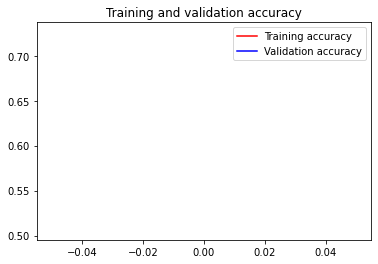

<Figure size 432x288 with 0 Axes>

In [247]:
import matplotlib.pyplot as plt

# Plot accuracy vs loss to gain a better understanding of the model's performance

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [278]:
# Predicts a fake tweet given a str

def predict_tweet(tweet):
    token_sequence = tokenizer.texts_to_sequences([tweet])[0]
    token_padded = pad_sequences([token_sequence], maxlen=max_length, truncating=trunc_type)
    predicted = model.predict(token_padded)
    predicted_class = model.predict_classes(token_padded)
    predicted_cat = str(cat_index[predicted_class].tolist())

    
    print(predicted)
    print(predicted_cat)
    
fake_tweet = "it was good"
predict_tweet(fake_tweet)

<class 'str'>
[[0.0350158  0.03096665 0.9340176 ]]
['positive']


In [ ]:
'''
TO DO:

- Improve model
- Improve training
-# Predict tweet method
- Visualizations such as
    - most common words
    - word embeddings, clustering
    -# model training graphs

'''